In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import os
import json
from matplotlib import pyplot as plt

In [ ]:
with open('/content/drive/MyDrive/archive/cat_to_name.json') as f:
    cat_cols=json.load(f)

n=list(range(len(cat_cols)))
cat_cols=[cat_cols[k] for k in sorted(cat_cols.keys())]

print(cat_cols)

cat_to_num=dict(zip(cat_cols, n))
num_to_cat=dict(zip( n, cat_cols))

print(num_to_cat)

['pink primrose', 'globe thistle', 'blanket flower', 'trumpet creeper', 'blackberry lily', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'hard-leaved pocket orchid', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'canterbury bells', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'sweet pea', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'english marigold', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'tiger lily', 'pink-yellow dahli

In [ ]:
trgen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

train_generator=trgen.flow_from_directory(
    directory='/content/drive/MyDrive/archive/dataset/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True

)

vgen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_generator=vgen.flow_from_directory(
    directory='/content/drive/MyDrive/archive/dataset/valid',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


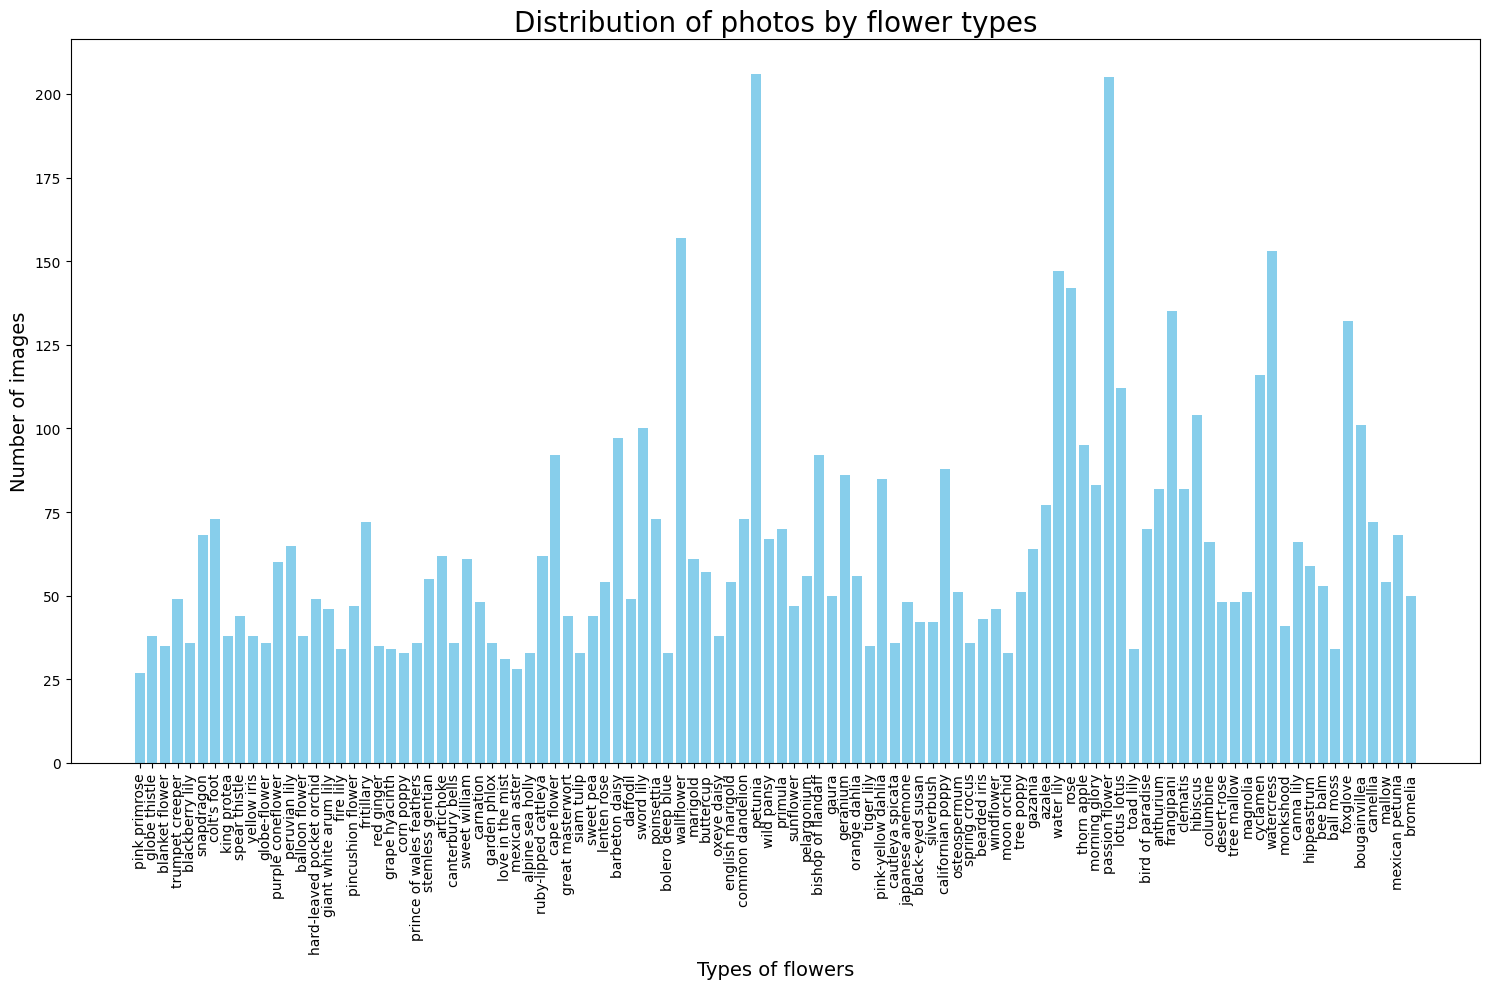

In [ ]:
classes=train_generator.classes
count_per_class=np.bincount(classes)
count_per_class

plt.figure(figsize=(15, 10))
plt.bar(cat_cols, count_per_class, color='skyblue')
plt.xlabel('Types of flowers', fontsize=14)
plt.ylabel('Number of images', fontsize=14)
plt.title('Distribution of photos by flower types', fontsize=20)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Сначала зафиксирую веса MobileNetV2 и обучу новый верхний слой

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)


base_model.trainable=False

x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
predictions=tf.keras.layers.Dense(102, activation='softmax')(x)

model=tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    min_delta=0.001,
    patience=4
)

model.fit(train_generator,
          validation_data=valid_generator,
          epochs=5,
          callbacks=[early_stopping])

Далее подгоняю веса MobileNetV2 под датасет цветов

In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(train_generator,
          validation_data=valid_generator,
          epochs=10,
          callbacks=[early_stopping])

model.save("flowers_model.h5")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.4125 - loss: 2.7467 - val_accuracy: 0.7861 - val_loss: 0.8246
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.8155 - loss: 0.6622 - val_accuracy: 0.8020 - val_loss: 0.6905
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8525 - loss: 0.4970 - val_accuracy: 0.8227 - val_loss: 0.5908
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.8904 - loss: 0.3752 - val_accuracy: 0.8570 - val_loss: 0.4961
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9137 - loss: 0.2971 - val_accuracy: 0.8521 - val_loss: 0.5249
Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.6832 - loss: 1.1978 - val_accuracy: 0.8692 - val_loss: 0.4896
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.8858 - loss: 0.4374 - val_accuracy: 0.8802 - val_loss: 0.4550
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.9127 - loss: 0.3302 - val_accuracy: 0.8924 - 